In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [9]:
271-len(df[(df.split=='train')])

28

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=512,size=512):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=8)

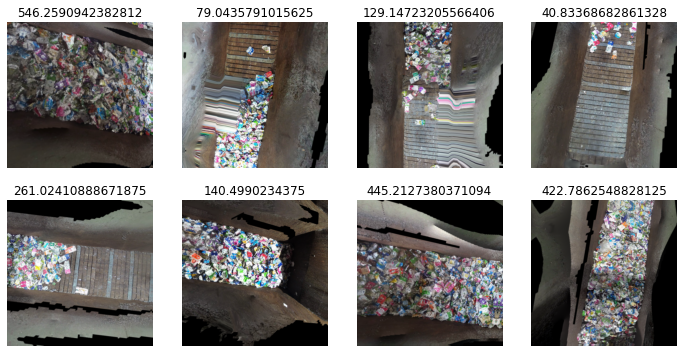

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='convnext_base_Masa')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = Learner(dls, timm.create_model('convnext_base',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,110104.007812,120476.382812,274.911469,347.097076,120476.382812,00:18


Better model found at epoch 0 with valid_loss value: 120476.3828125.


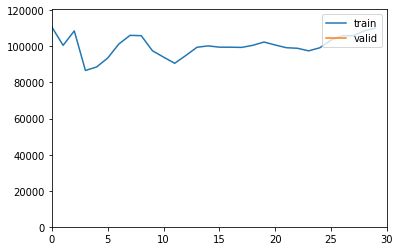

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,104955.984375,120058.265625,274.145569,346.494263,120058.265625,00:18
1,104037.640625,119428.687500,272.995453,345.584534,119428.687500,00:18
2,104603.062500,118773.273438,271.793152,344.634979,118773.273438,00:18
3,103523.789062,118082.632812,270.518890,343.631531,118082.632812,00:19
4,103171.312500,117353.210938,269.167328,342.568542,117353.210938,00:19
5,102672.351562,116606.539062,267.776703,341.476990,116606.539062,00:19
6,100897.445312,115838.750000,266.339203,340.350922,115838.750000,00:19
7,100624.945312,115050.242188,264.854828,339.190582,115050.242188,00:19
8,99911.820312,114225.015625,263.292328,337.971924,114225.015625,00:19
9,97915.179688,113388.320312,261.698578,336.731812,113388.320312,00:19


Better model found at epoch 0 with valid_loss value: 120058.265625.


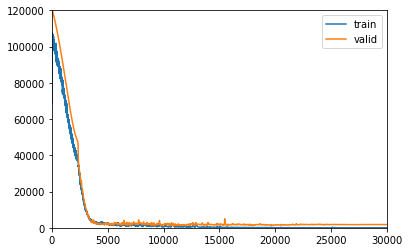

Better model found at epoch 1 with valid_loss value: 119428.6875.
Better model found at epoch 2 with valid_loss value: 118773.2734375.
Better model found at epoch 3 with valid_loss value: 118082.6328125.
Better model found at epoch 4 with valid_loss value: 117353.2109375.
Better model found at epoch 5 with valid_loss value: 116606.5390625.
Better model found at epoch 6 with valid_loss value: 115838.75.
Better model found at epoch 7 with valid_loss value: 115050.2421875.
Better model found at epoch 8 with valid_loss value: 114225.015625.
Better model found at epoch 9 with valid_loss value: 113388.3203125.
Better model found at epoch 10 with valid_loss value: 112540.421875.
Better model found at epoch 11 with valid_loss value: 111641.3125.
Better model found at epoch 12 with valid_loss value: 110772.265625.
Better model found at epoch 13 with valid_loss value: 109869.078125.
Better model found at epoch 14 with valid_loss value: 108932.578125.
Better model found at epoch 15 with valid_los

Better model found at epoch 142 with valid_loss value: 1998.0135498046875.
Better model found at epoch 147 with valid_loss value: 1988.6785888671875.
Better model found at epoch 148 with valid_loss value: 1936.2374267578125.
Better model found at epoch 153 with valid_loss value: 1837.4110107421875.
Better model found at epoch 155 with valid_loss value: 1804.573486328125.
Better model found at epoch 165 with valid_loss value: 1794.10546875.
Better model found at epoch 166 with valid_loss value: 1780.480712890625.
Better model found at epoch 168 with valid_loss value: 1490.5050048828125.
Better model found at epoch 296 with valid_loss value: 1400.34375.
Better model found at epoch 329 with valid_loss value: 1390.118896484375.
Better model found at epoch 353 with valid_loss value: 1348.048095703125.
Better model found at epoch 363 with valid_loss value: 1022.1438598632812.


In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
learn.load('convnext_base_Masa')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [22]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [23]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [24]:
dlstest = dbtest.dataloaders(path,bs=8)

In [25]:
learn.dls=dlstest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 29.310047149658203.


(#4) [2646.186279296875,29.310047149658203,51.44109344482422,2646.186279296875]

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
preds,gt = learn.tta()

In [29]:
mean_absolute_error(gt,preds)

29.26175